In [1]:
# Setup logging
from timeseria import logger
logger.setup(level='INFO')

# Set default plot type as image
import os
os.environ["DEFAULT_PLOT_TYPE"] = "image"

⚠️ In this notebook plots are set to be rendered in image format by default, as otherwise they will not be displayed on GitHub or when loading it (usually because not [trusted](https://stackoverflow.com/questions/44943646/jupyter-notebook-not-trusted)). To get interactive plots, remove the line above (or change it to "interactive") and re-run the notebook. 


# Temperature forecasting with periodic averages


This notebook showcase the periodic average forecatser of [Timeseria](https://github.com/sarusso/Timeseria).

This is a very simple (yet somehow powerful) forecaster which simply computes the periodicity in the data and then the average values within that period. It fits nearly instantaneously and it has the very same interfaces as its more powerful counterparts as the neural network-based ones, making it perfect for demonstrative purposes.

Let's start by loading an example time series:

In [2]:
from timeseria import storages, TEST_DATASETS_PATH

# Create a CSV storage pointing to a temperature dataset
csv_storage = storages.CSVFileStorage(TEST_DATASETS_PATH + 'temperature.csv')

# Get the time series from the CSV file storage
timeseries = csv_storage.get()

Have a look at the time series we just loaded 

In [3]:
timeseries

Time series of #18331 points at variable resolution (~10m), from point @ 1546477200.0 (2019-01-03 01:00:00+00:00) to point @ 1557960000.0 (2019-05-15 22:40:00+00:00)

[INFO] timeseria.plots: Aggregating by "10" for improved plotting


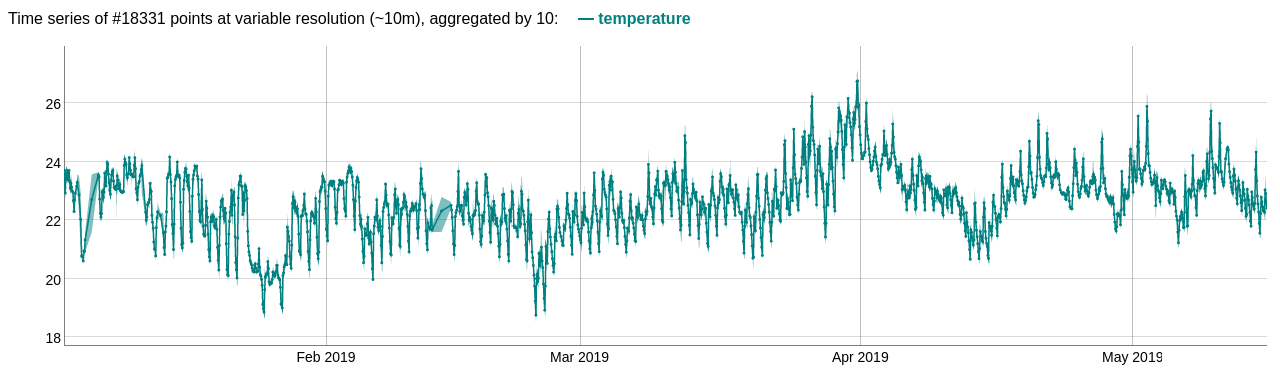

In [4]:
timeseries.plot()

Resample to one hour, and make data uniform

In [5]:
hourly_timeseries = timeseries.resample('1h')

[INFO] timeseria.transformations: Using auto-detected sampling interval: 600.0s
[INFO] timeseria.transformations: Resampled 18331 DataTimePoints in 3189 DataTimePoints


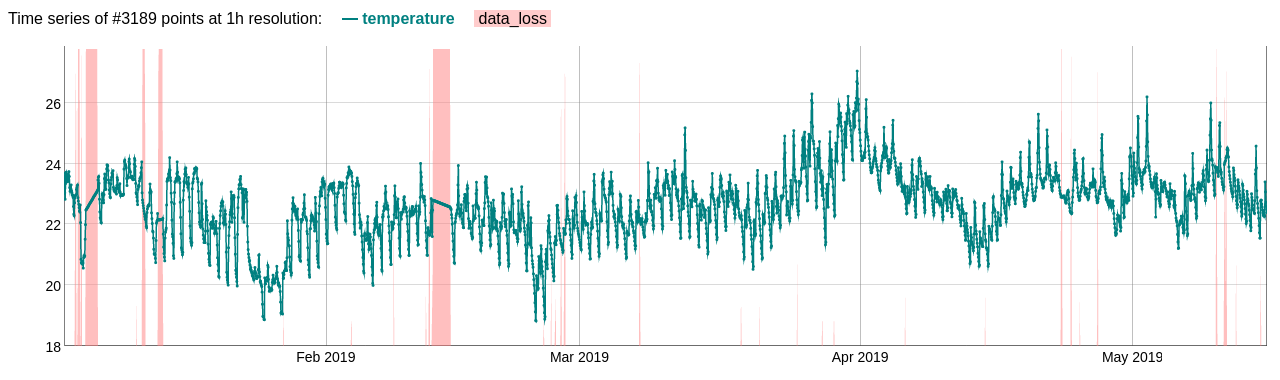

In [6]:
hourly_timeseries.plot()

Instantiate and fit the model

In [7]:
from timeseria.models import PeriodicAverageForecaster

forecaster = PeriodicAverageForecaster()
forecaster.fit(hourly_timeseries)

[INFO] timeseria.models.forecasters: Detected periodicity: 24x 1h
[INFO] timeseria.models.forecasters: Using a window of "24"


Call the `predict()` function of the model. This returns key-value data with the prediction values

In [8]:
forecaster.predict(hourly_timeseries)

[{'temperature': 22.323348033780558}]

The timeseries on which to call the predict has to be at least of 24 hours (the window length):

In [9]:
try:
    forecaster.predict(hourly_timeseries[0:23])
except Exception as e:
    print(e)

The series length (23) is shorter than the model window (24), it must be at least equal.


The predict function of this forecaster can also take as argument how many steps-ahead to predict

In [10]:
forecaster.predict(hourly_timeseries, steps=3)

[{'temperature': 22.323348033780558},
 {'temperature': 22.112754678010734},
 {'temperature': 21.893528324687868}]

To get also the timestamps, use the `forecast()` method, which returns data point objects:

In [11]:
forecaster.forecast(hourly_timeseries, steps=3)

[Time point @ 1557961200.0 (2019-05-15 23:00:00+00:00) with data "{'temperature': 22.323348033780558}",
 Time point @ 1557964800.0 (2019-05-16 00:00:00+00:00) with data "{'temperature': 22.112754678010734}",
 Time point @ 1557968400.0 (2019-05-16 01:00:00+00:00) with data "{'temperature': 21.893528324687868}"]

The `apply()` method allows instead to directly apply the model on a time series (by combining the forecasts with the real observations)

In [12]:
hourly_timeseries_with_forecast = forecaster.apply(hourly_timeseries, steps=24*3)

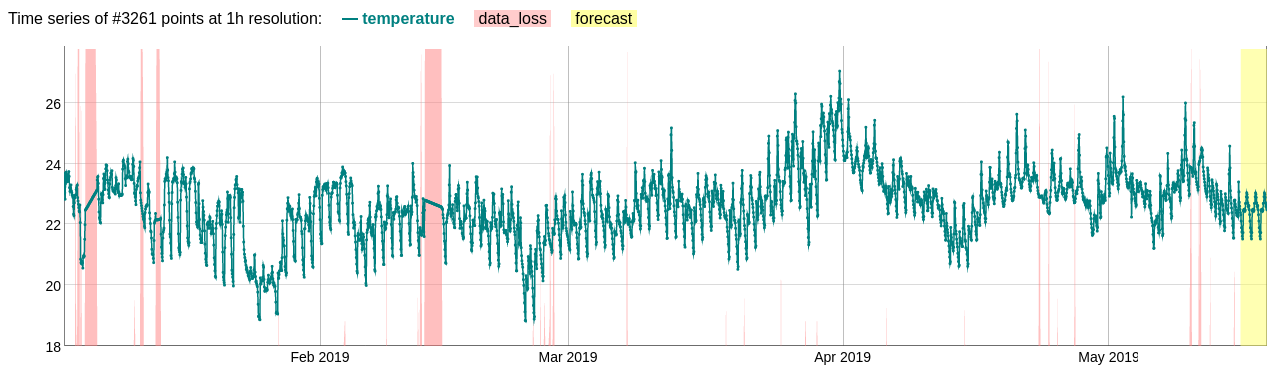

In [13]:
hourly_timeseries_with_forecast.plot()

Forecasters also supports the `evaluate()` method to evaluate them. By default, window-based forecasters get evaluated on one step ahead and on a number of steps ahead equal to the window length, with RMSE and MAE metrics:

In [14]:
forecaster.evaluate(hourly_timeseries)

[INFO] timeseria.models.forecasters: Will evaluate model for [1, 24] steps ahead with metrics ['RMSE', 'MAE']


{'RMSE': 0.6187106383406303, 'MAE': 0.46844984996838346}

For more advanced evaulations, including using other metrics and plotting the prediction, check out the "Forecasting - Advanced Evaluation" notebook.